In [1]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import os
# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from textblob import TextBlob
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import nltk
nltk.download('opinion_lexicon')


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# Get the current working directory
current_dir = os.getcwd()
# Move up one level from the current directory
parent_dir = os.path.dirname(current_dir)
# Read the dataset
df = pd.read_csv(os.path.join(parent_dir, 'dataset', 'clean_data.csv'))

In [5]:
df.head()

,id,verified,date_review,day_review,month_review,month_review_num,year_review,verified.1,name,month_fly,...,seat_type,route,seat_comfort,cabit_serv,food,ground_service,wifi,money_value,recommended,review
0,0,True,2024-03-26,26,March,3,2024,True,Troy Robinson,March,...,Business Class,London to Tokyo,5.0,2.0,5.0,3.0,NaN,4,yes,"A last minute business trip to HND, a route I ..."
1,1,True,2024-03-26,26,March,3,2024,True,R Norton,March,...,Economy Class,Lisbon to London,4.0,3.0,NaN,1.0,NaN,3,yes,Overall I would say disappointing. Due to BA s...
2,2,False,2024-03-25,25,March,3,2024,False,Paul Lee,February,...,Business Class,London to Delhi,5.0,5.0,5.0,5.0,NaN,5,yes,LHR to Delhi in Business. Exceptional flight. ...
3,3,False,2024-03-25,25,March,3,2024,False,Paul Lee,March,...,Economy Class,London to Milan,5.0,5.0,5.0,4.0,NaN,5,yes,Efficient and Smooth flight from start to fini...
4,4,True,2024-03-25,25,March,3,2024,True,Peter Buchanan,March,...,Economy Class,Madrid to London Heathrow,3.0,3.0,NaN,3.0,NaN,2,no,Was told we can not take hand luggage onto the...


In [6]:
df.columns

Index(['id', 'verified', 'date_review', 'day_review', 'month_review',
       'month_review_num', 'year_review', 'verified.1', 'name', 'month_fly',
       'month_fly_num', 'year_fly', 'month_year_fly', 'country', 'aircraft',
       'type', 'seat_type', 'route', 'seat_comfort', 'cabit_serv', 'food',
       'ground_service', 'wifi', 'money_value', 'recommended', 'review'],
      dtype='object')

In [7]:
df = df[['seat_comfort', 'cabit_serv', 'food','ground_service', 'wifi','review', 'money_value','recommended']]

In [8]:
df.head()

,seat_comfort,cabit_serv,food,ground_service,wifi,review,money_value,recommended
0,5.0,2.0,5.0,3.0,NaN,"A last minute business trip to HND, a route I ...",4,yes
1,4.0,3.0,NaN,1.0,NaN,Overall I would say disappointing. Due to BA s...,3,yes
2,5.0,5.0,5.0,5.0,NaN,LHR to Delhi in Business. Exceptional flight. ...,5,yes
3,5.0,5.0,5.0,4.0,NaN,Efficient and Smooth flight from start to fini...,5,yes
4,3.0,3.0,NaN,3.0,NaN,Was told we can not take hand luggage onto the...,2,no


## General Word Frequency Analysis

In [9]:
def negative_word_cloud(df):
    # Combine all reviews into a single string
    reviews_text = ' '.join(df['review'].dropna())

    # Tokenize the text
    tokens = word_tokenize(reviews_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # Perform sentiment analysis to identify negative words
    sid = SentimentIntensityAnalyzer()
    negative_words = [word for word in filtered_tokens if sid.polarity_scores(word)['compound'] < 0]

    # Initialize Porter Stemmer
    stemmer = PorterStemmer()

    # Example dictionary of similar words
    word_groups = {
        'delayed': 'delay',
        'cancelled': 'cancel'
        # Add more groups as needed
    }

    # Update negative words based on groups and stemming
    negative_words_grouped = []
    for word in negative_words:
        # Stem the word using Porter Stemmer
        stemmed_word = stemmer.stem(word)
        
        # Check if the stemmed word is in the word groups
        for group_word, group_root in word_groups.items():
            if group_word in stemmed_word:
                stemmed_word = group_root
                break
        
        # Add the stemmed word to the grouped negative words
        negative_words_grouped.append(stemmed_word)

    # Combine negative words into a single string
    negative_text_grouped = ' '.join(negative_words_grouped)

    # Create and generate the word cloud
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(negative_text_grouped)

    # Display the word cloud
    plt.figure(figsize=(8, 8), facecolor=None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad=0) 
    plt.show()

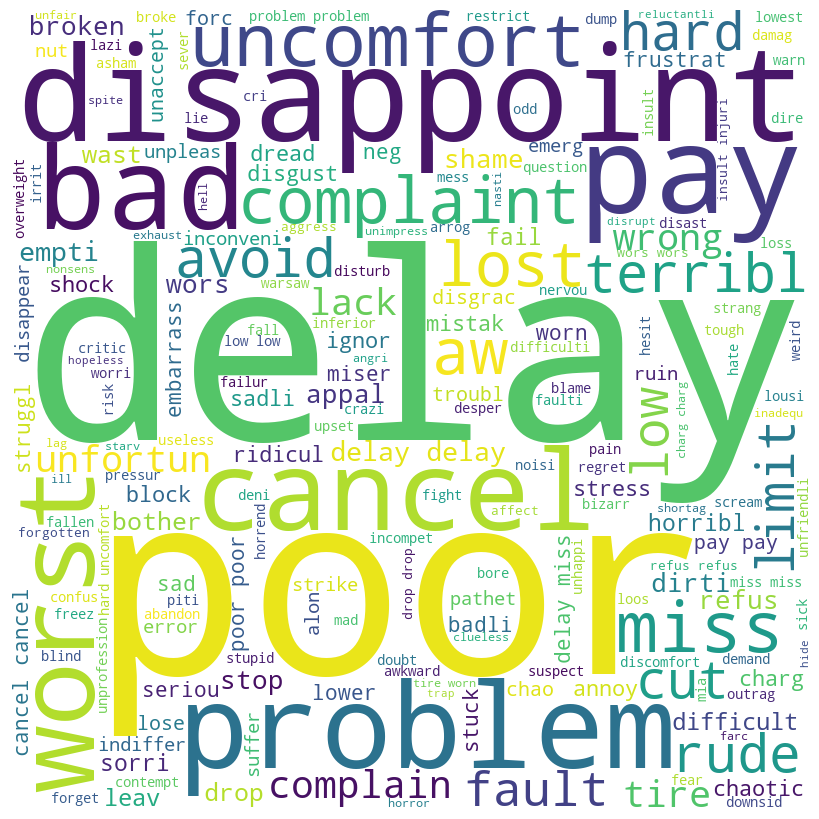

In [10]:
negative_word_cloud(df)

In [11]:
def calculate_percentage(df, *keywords):
    """
    Calculate the percentage of flights that contain specific keywords in the 'review' column.

    Parameters:
    df (DataFrame): DataFrame containing a 'review' column.
    *keywords: Variable length list containing the keywords to search for in the 'review' column.

    Returns:
    None
    """
    for keyword_list in keywords:
        # Function to check if the review contains all the keywords in the list
        def check_keyword(review):
            return all(kw.lower() in review.lower() for kw in keyword_list)

        # Apply the function to create the column
        df['_'.join(keyword_list).lower()] = df['review'].apply(check_keyword).astype(int)
        
        # Calculate the percentage and round to two decimal places
        percentage = round((df['_'.join(keyword_list).lower()].mean()) * 100, 2)

        print(f"Percentage of flights that have {', '.join(keyword_list)} problem: {percentage}%")

calculate_percentage(df, ["lost", "luggage"],['miss','wait'], ["delay"],['cancel'], ['uncomfortable','seat'],['staff'])

Percentage of flights that have lost, luggage problem: 1.38%
Percentage of flights that have miss, wait problem: 2.38%
Percentage of flights that have delay problem: 18.19%
Percentage of flights that have cancel problem: 8.98%
Percentage of flights that have uncomfortable, seat problem: 5.72%
Percentage of flights that have staff problem: 30.35%


In [12]:
def print_sentences_near_word(df, input_word):
    """
    Print the sentences containing the input word in the 'review' DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing a 'review' column.
    input_word (str): The word to find the nearest sentences from.

    Returns:
    None
    """
    # Iterate through each review in the DataFrame
    for review in df['review']:
        # Split the review into sentences
        review_sentences = review.split('.')

        # Iterate through each sentence in the review
        for sentence in review_sentences:
            # Check if the input word is in the sentence
            if input_word.lower() in sentence.lower():
                # Print the sentence with surrounding context
                print(sentence.strip())

print_sentences_near_word(df, "staff")

Staff utterly incompetent
BA is not what it used to be! As much as I like their onboard crew their check in staff lacked interest in their job and safety
During the entire flight all the staff felt like they hated being on the flight and did not want to work
I confirmed with the staff at Singapore that I'll make it just fine for my connecting flight since it was just an hour delay vs a few hours in transit
I arrived in Sydney, the flight was fine and the BA staff were decent
Staff are courteous and professional; the issue is the quality of the product for the price
The check-in at the airport was very quick and smooth, with friendly staff
During the flight I felt that a staff member was very unprofessional towards me
It took nearly 50 minutes of phone calls and numerous staff to check us in for a redemption flight through our account
Baggage of other flights arriving after had been delivered whereas the baggage staff on airport had no clue and information as to why baggage of this flig

## Sentiment Analysis

In [13]:
# Define a function to calculate sentiment polarity using TextBlob
def calculate_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

In [14]:
# Apply the function to your review column
df['sentiment_score'] = df['review'].apply(calculate_sentiment)

In [15]:
df['sentiment_score'].describe()

count    3776.000000
mean        0.090672
std         0.179828
min        -0.766667
25%        -0.021168
50%         0.079575
75%         0.200590
max         0.800000
Name: sentiment_score, dtype: float64

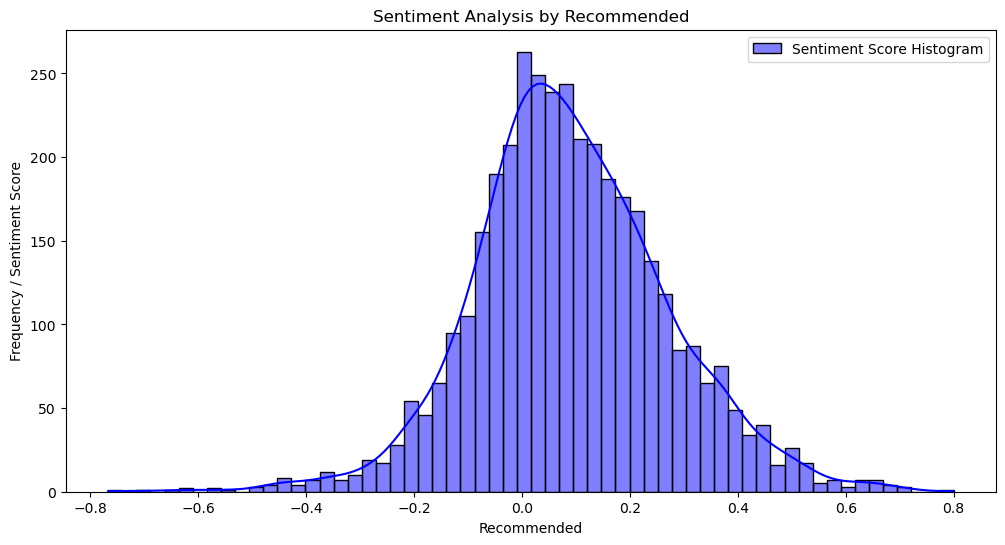

In [45]:
# Create a combo chart
plt.figure(figsize=(12, 6))

# Plot histogram with kernel density estimate
sns.histplot(df['sentiment_score'], bins=60, color='blue', kde=True, label='Sentiment Score Histogram')

plt.title('Sentiment Analysis by Recommended')
plt.xlabel('Recommended')
plt.ylabel('Frequency / Sentiment Score')
plt.legend()

plt.show()


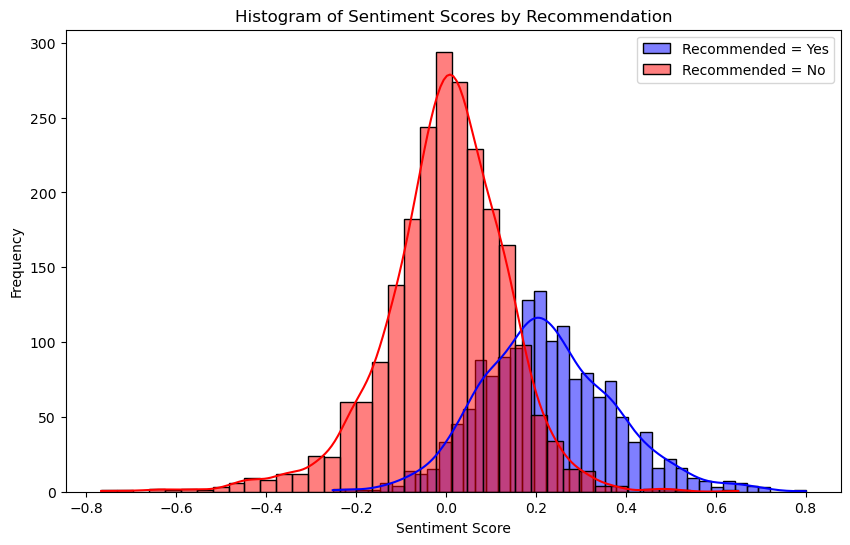

In [17]:
# Create histograms for sentiment scores based on 'Recommended' column
plt.figure(figsize=(10, 6))

sns.histplot(df[df['recommended'] == 'yes']['sentiment_score'], bins=40, color='blue', label='Recommended = Yes', kde=True)
sns.histplot(df[df['recommended'] == 'no']['sentiment_score'], bins=40, color='red', label='Recommended = No', kde=True)

plt.title('Histogram of Sentiment Scores by Recommendation')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [46]:
# Group sentiment score by Recommended column
grouped_data = df.groupby('recommended')['sentiment_score'].agg(['max', 'min', 'mean', 'median']).reset_index()
grouped_data

,recommended,max,min,mean,median
0,0,0.65,-0.766667,0.000001,0.00750
1,1,0.80,-0.251667,0.224804,0.21452


In [47]:
df.head()

,seat_comfort,cabit_serv,food,ground_service,wifi,review,money_value,recommended,lost_luggage,miss_wait,delay,cancel,uncomfortable_seat,staff,sentiment_score
0,5.0,2.0,5.0,3.0,NaN,"A last minute business trip to HND, a route I ...",4,1,0,0,0,0,0,0,0.071717
1,4.0,3.0,NaN,1.0,NaN,Overall I would say disappointing. Due to BA s...,3,1,0,0,1,0,0,0,-0.123229
2,5.0,5.0,5.0,5.0,NaN,LHR to Delhi in Business. Exceptional flight. ...,5,1,0,0,0,0,0,0,0.503788
3,5.0,5.0,5.0,4.0,NaN,Efficient and Smooth flight from start to fini...,5,1,0,0,0,0,0,0,0.525333
4,3.0,3.0,NaN,3.0,NaN,Was told we can not take hand luggage onto the...,2,0,0,0,1,0,0,0,-0.150000


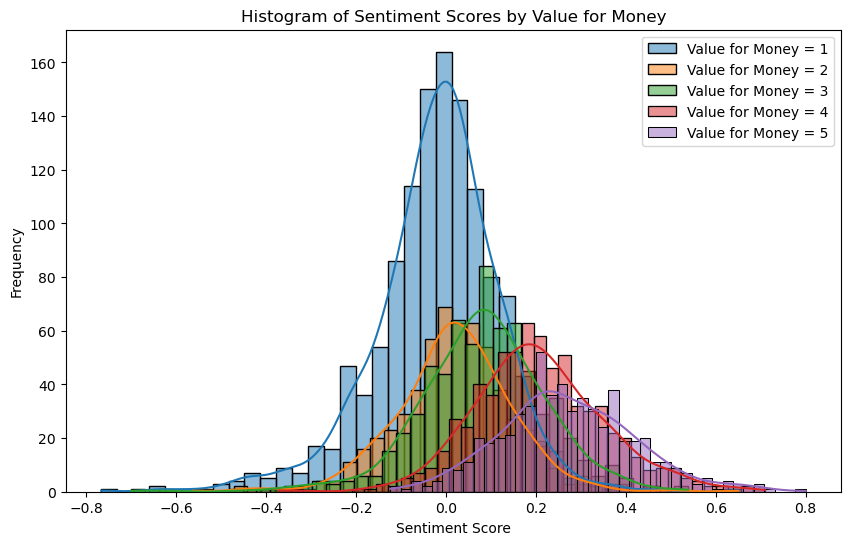

In [48]:
plt.figure(figsize=(10, 6))

# Plot histograms for 'Value for Money' scores
for value in range(1, 6):
    sns.histplot(df[df['money_value'] == value]['sentiment_score'], bins=40, label=f'Value for Money = {value}', kde=True)

plt.title('Histogram of Sentiment Scores by Value for Money')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [21]:
# Map 'yes' to 1 and 'no' to 0 in the 'Recommended' column
df['recommended'] = df['recommended'].map({'yes': 1, 'no': 0})

## Root Cause Analysis

In [22]:
def filter_reviews_and_percentage(df, word='food'):
    """
    Filter the DataFrame to contain only the reviews containing the specified word.
    Print out the percentage of reviews containing the specified word.

    Args:
    - df: DataFrame containing the 'review' column.
    - word: The word to search for in the 'review' column. Default is 'food'.

    Returns:
    - DataFrame containing only the reviews containing the specified word.
    """

    # Filter the DataFrame to contain only the reviews containing the specified word
    filtered_df = df[df['review'].str.contains(word, case=False)]

    # Calculate the percentage of reviews containing the specified word
    total_reviews = len(df)
    reviews_with_word = len(filtered_df)
    percentage = (reviews_with_word / total_reviews) * 100

    # Print out the percentage
    print(f"Percentage of reviews containing the word '{word}': {percentage:.2f}%")

    # Return the filtered DataFrame
    return filtered_df

### Ground Staff experience Analysis (London/Heathrow)

In [49]:
staff_df = pd.read_csv(os.path.join(parent_dir, 'dataset', 'bad_staff.csv'))

In [50]:
# Apply the function to your review column
staff_df['sentiment_score'] = staff_df['review'].apply(calculate_sentiment)

In [51]:
staff_df['sentiment_score'].describe()

count    262.000000
mean      -0.019430
std        0.126462
min       -0.441667
25%       -0.083222
50%       -0.004194
75%        0.057069
max        0.258333
Name: sentiment_score, dtype: float64

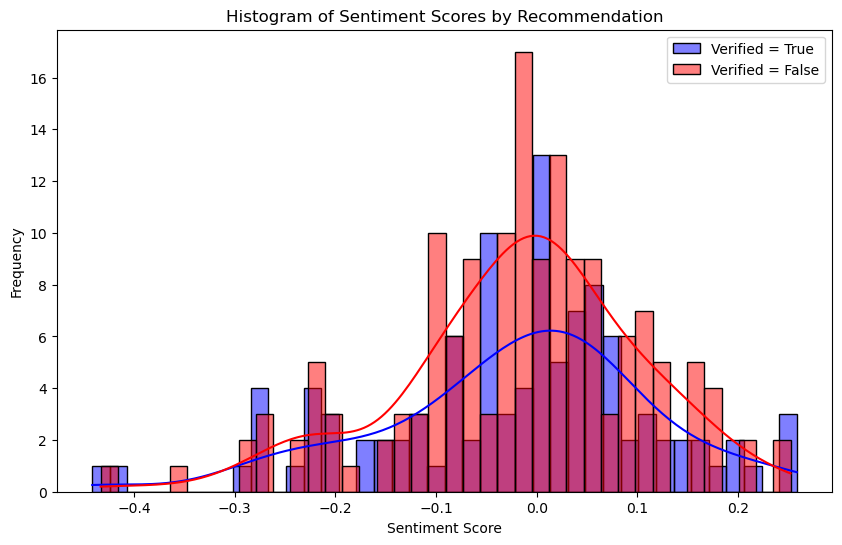

In [52]:
# Create histograms for sentiment scores based on 'Recommended' column
plt.figure(figsize=(10, 6))

sns.histplot(staff_df[staff_df['verified'] == True]['sentiment_score'], bins=40, color='blue', label='Verified = True', kde=True)
sns.histplot(staff_df[staff_df['verified'] == False]['sentiment_score'], bins=40, color='red', label='Verified = False', kde=True)

plt.title('Histogram of Sentiment Scores by Recommendation')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [54]:
print_sentences_near_word(staff_df[staff_df['sentiment_score']<0], "staff")

Unfortunately we were stranded in the plane and waited a very long time to disembark the plane due to lack of staff or slot shortage (it’s a common problem with BA at Heathrow)
Cabin staff don't bother implementing their own rules
Anyone with a connecting flight couldn't rebook on the application because the app wouldn't disassociate our first flight with the connecting one in London and the staff saw this but still refused to help us
The worst thing was the utter callousness that staff showed towards customers
The ground staff’s attitude was that they are merely third party agents, not BA employees, and therefore they quickly washed their hands of us all, telling us we had to contact BA directly via phone if we wanted help
I guess staff are badly paid from their terrible attitude and service
The staff are very rude and not trained properly
2) Staff demanded that we check in our carry on luggage even though we met our carry on allowance
3) Staff were quite unpleasant
A single BA staff 

In [64]:
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...


True

In [67]:
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn

def generate_negative_adjective_wordcloud(dataframe, word):
    """
    Generate a word cloud of negative adjectives associated with the given word in the provided DataFrame,
    considering only sentences that contain the specified word.

    Parameters:
    - dataframe (pandas.DataFrame): DataFrame containing text data.
    - word (str): The word to find associated negative adjectives with.

    Returns:
    - None (displays the word cloud)
    """

    # Function to filter negative adjectives from text using SentWordNet
    def filter_negative_adjectives(text):
        words = word_tokenize(text)
        negative_adjectives = []
        for word in words:
            senti_synsets = list(swn.senti_synsets(word, 'a'))
            for synset in senti_synsets:
                if synset.neg_score() > synset.pos_score():
                    negative_adjectives.append(synset.synset.name().split('.')[0])
        return negative_adjectives

    # Extract negative adjectives associated with the specified word
    negative_adjectives = []
    for review in dataframe[dataframe['review'].str.contains(word)]['review']:  # Filter sentences containing the word
        negative_adjectives.extend(filter_negative_adjectives(review))

    # Join the negative adjectives into a single string for the word cloud
    negative_adjectives_text = ' '.join(negative_adjectives)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_adjectives_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Negative Adjectives Associated with ' + word)
    plt.axis('off')
    plt.show()

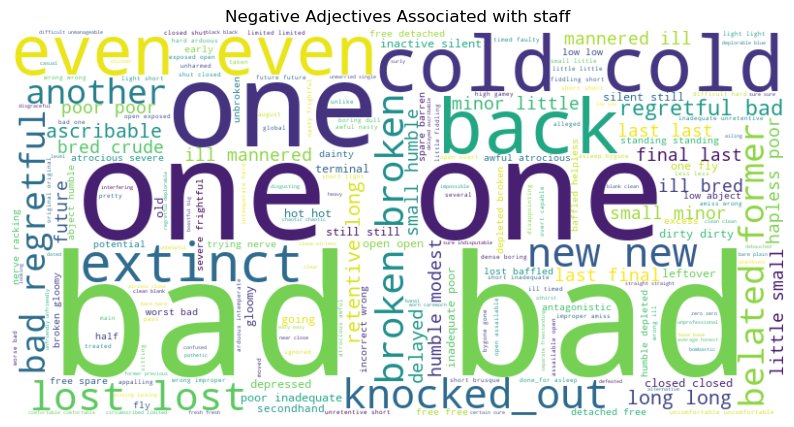

In [68]:
generate_negative_adjective_wordcloud(staff_df,'staff')

In [70]:
calculate_percentage(staff_df[staff_df['sentiment_score']<0], ["rude"],['useless'], ['ground','staff'],['paid'],['slow'],['useless'])

Percentage of flights that have rude problem: 25.56%
Percentage of flights that have useless problem: 2.26%
Percentage of flights that have ground, staff problem: 13.53%
Percentage of flights that have paid problem: 8.27%
Percentage of flights that have slow problem: 6.02%
Percentage of flights that have useless problem: 2.26%


### Airplane food experience analysis

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [71]:
food_df = pd.read_csv(os.path.join(parent_dir, 'dataset', 'bad_food.csv'))

In [72]:
print_sentences_near_word(food_df, "food")

The food I had was average, I had a cocktail it was OK
The flight crew were giving the welcome drinks as if giving free food at a food bank and I wasn't offered a non-alcoholic choice due to sitting on the last row of business class cabin
I was quite underwhelmed by the food provided on board
A very long time ago the food and beverage service on BA was truly extraordinary - today it would be a bit of a stretch to even call it ordinary - so sad a decline
Seat comfort (in First), lounges food, beverage all need serious rework
The food is not much better
Couldn't recline, no entertainment for the 5hr+ flight, uncomfortable seat and disgusting food
This airline is a total disgrace, the crew were not nice, typical BA crew oh im so fabulous I don't need to be nice to paying passengers, club europe cramped and terrible food!
They didn't load any food on to the plane and forgot to load the baggage for all the business class passengers who had been on the earlier flight
The food in business cla

In [73]:
calculate_percentage(food_df, ["terrible"],['cold'],['disgusting'])

Percentage of flights that have terrible problem: 7.52%
Percentage of flights that have cold problem: 8.01%
Percentage of flights that have disgusting problem: 4.85%


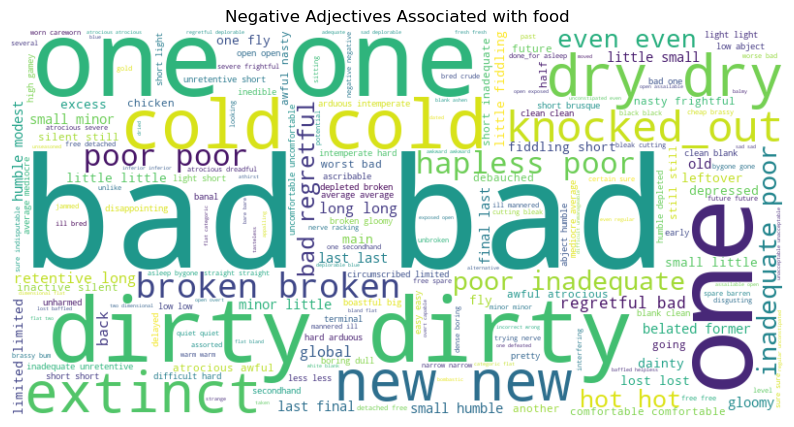

In [74]:
generate_negative_adjective_wordcloud(food_df,'food')

### Airplane seat experience analysis

In [75]:
seat_df = pd.read_csv(os.path.join(parent_dir, 'dataset', 'bad_seat.csv'))

In [76]:
print_sentences_near_word(seat_df, "seat")

I found my seat sat down and waited for someone to offer me a refreshment
It barely rates as premium economy, and BA shouldn't be suggesting that they are offering premium seating on regional routes in Europe
On these routes, BA has crammed their seats so close together that the experience is like flying on a discount airline
Buyer beware, there is no point in upgrading to business class, other than ensuring the middle seat is empty and you and your bag can board first
The seats are extremely uncomfortable, and they can't really be reclined
As we were checking I was told the flight was over booked and our seats wouldn't print onto the ticket for some reason
We had already made sure the seats were booked when we had booked the flights nearly a year prior to going
Business lounge overfull, couldn't get seats
Food was poor, they gave you wipes to clean your seat area yourself and we were split up so they could accommodate families
Hard, thin, uncomfortable seats, poor legroom and the cabi

In [77]:
calculate_percentage(seat_df, ["uncomfortable"],['yin-yang'])

Percentage of flights that have uncomfortable problem: 11.4%
Percentage of flights that have yin-yang problem: 0.0%


## Topic Modelling

In [78]:
from gensim.models import Word2Vec

In [79]:
# Tokenize the reviews and remove stopwords
stop_words = set(stopwords.words('english'))
tokenized_reviews = [word_tokenize(review.lower()) for review in staff_df['review']]
reviews = [[word for word in review if word.isalnum() and word not in stop_words] for review in tokenized_reviews]

# Train the Word2Vec model
word2vec_model = Word2Vec(reviews, vector_size=300, window=5, min_count=1, workers=4)

# Define keywords indicative of each category
staff_keywords = ['not_helpful', 'unprofessional', 'rude']
understaff_keywords = ['lack', 'useless']  # Adding 'useless' as a similar word

# Function to categorize reviews based on word vectors
def categorize_review(review):
    review_tokens = [word for word in word_tokenize(review.lower()) if word.isalnum() and word not in stop_words]

    # Calculate similarity with staff keywords
    staff_similarities = [word2vec_model.wv.similarity(keyword, word) for keyword in staff_keywords for word in review_tokens if word in word2vec_model.wv.key_to_index and keyword in word2vec_model.wv.key_to_index]
    staff_similarity_score = sum(staff_similarities) / len(staff_similarities) if staff_similarities else 0

    # Calculate similarity with understaff keywords
    understaff_similarities = [word2vec_model.wv.similarity(keyword, word) for keyword in understaff_keywords for word in review_tokens if word in word2vec_model.wv.key_to_index and keyword in word2vec_model.wv.key_to_index]
    understaff_similarity_score = sum(understaff_similarities) / len(understaff_similarities) if understaff_similarities else 0

    # Categorize review based on similarity scores
    if staff_similarity_score > understaff_similarity_score:
        return 'Staff Problems'
    elif understaff_similarity_score > staff_similarity_score:
        return 'Understaff Problems'
    else:
        return 'Other Problems'

# Apply categorization function to each review
staff_df['review_topic'] = staff_df['review'].apply(categorize_review)

# Display the distribution of topics
print(staff_df['review_topic'].value_counts())

review_topic
Staff Problems    262
Name: count, dtype: int64


In [80]:
target_sentence = "staff"
staff_df.loc[staff_df['review'].str.contains(target_sentence)][['review','review_topic']]

,review,review_topic
0,BA is not what it used to be! As much as I lik...,Staff Problems
1,London Heathrow to Istanbul at the start of th...,Staff Problems
2,I recently had a delay on British Airways from...,Staff Problems
3,Booked a flight from Bucharest to Manchester w...,Staff Problems
4,BA has a real problem with boarding it's fligh...,Staff Problems
...,...,...
257,"Day trip to Vienna, used BA Economy as their B...",Staff Problems
258,Having encouraged passengers to check-in onlin...,Staff Problems
259,If I could give it a Zero I would. From the mo...,Staff Problems
260,"Flew back 30 June, LGW-MCO flight delayed at G...",Staff Problems


In [81]:
def filter_review_sentences_with_staff(review):
    """
    Modify the review column to only include sentences containing the word 'staff'.

    Parameters:
    review (str): The review text.

    Returns:
    str: The modified review text containing only sentences with the word 'staff'.
    """
    from nltk.tokenize import sent_tokenize

    # Tokenize the review into sentences
    sentences = sent_tokenize(review)

    # Filter sentences containing the word 'staff'
    filtered_sentences = [sentence for sentence in sentences if 'staff' in sentence.lower()]

    # Join the filtered sentences into a single string
    modified_review = ' '.join(filtered_sentences)

    return modified_review

# Apply the function to modify the 'review' column
staff_df['staff_review'] = staff_df['review'].apply(filter_review_sentences_with_staff)

In [82]:
target_sentence = "staff"
staff_problems = staff_df.loc[staff_df['staff_review'].str.contains(target_sentence)][['staff_review','review_topic']]
staff_problems.to_csv(os.path.join(parent_dir, 'dataset', 'london_staff_problems.csv'))